# Use Double DQN to Play MoutainCar-v0

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools
import copy

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(0)

imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('MountainCar-v0')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

20:28:17 [INFO] env: <MountainCarEnv<MountainCar-v0>>
20:28:17 [INFO] action_space: Discrete(3)
20:28:17 [INFO] observation_space: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
20:28:17 [INFO] reward_range: (-inf, inf)
20:28:17 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 30}
20:28:17 [INFO] _max_episode_steps: 200
20:28:17 [INFO] _elapsed_steps: None


In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class DoubleDQNAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99

        self.replayer = DQNReplayer(10000)

        self.evaluate_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[64, 64], output_size=self.action_n)
        self.optimizer = optim.Adam(self.evaluate_net.parameters(), lr=0.001)
        self.loss = nn.MSELoss()

    def build_net(self, input_size, hidden_sizes, output_size):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        model = nn.Sequential(*layers)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []
            self.target_net = copy.deepcopy(self.evaluate_net)

    def step(self, observation, reward, done):
        if self.mode == 'train' and np.random.rand() < 0.001:
            # epsilon-greedy policy in train mode
            action = np.random.randint(self.action_n)
        else:
            state_tensor = torch.as_tensor(observation,
                    dtype=torch.float).reshape(1, -1)
            q_tensor = self.evaluate_net(state_tensor)
            action_tensor = torch.argmax(q_tensor)
            action = action_tensor.item()
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                state, _, _, action, next_state, reward, done, _ = \
                        self.trajectory[-8:]
                self.replayer.store(state, action, reward, next_state, done)
            if self.replayer.count >= self.replayer.capacity * 0.95:
                    # skip first few episodes for speed
                self.learn()
        return action

    def close(self):
        pass

    def learn(self):
        # replay
        states, actions, rewards, next_states, dones = \
                self.replayer.sample(1024) # replay transitions
        state_tensor = torch.as_tensor(states, dtype=torch.float)
        action_tensor = torch.as_tensor(actions, dtype=torch.long)
        reward_tensor = torch.as_tensor(rewards, dtype=torch.float)
        next_state_tensor = torch.as_tensor(next_states, dtype=torch.float)
        done_tensor = torch.as_tensor(dones, dtype=torch.float)

        # train
        next_eval_q_tensor = self.evaluate_net(next_state_tensor)
        next_action_tensor = next_eval_q_tensor.argmax(axis=-1)
        next_q_tensor = self.target_net(next_state_tensor)
        next_max_q_tensor = torch.gather(next_q_tensor, 1,
                next_action_tensor.unsqueeze(1)).squeeze(1)
        target_tensor = reward_tensor + self.gamma * (1. - done_tensor) * next_max_q_tensor
        pred_tensor = self.evaluate_net(state_tensor)
        q_tensor = pred_tensor.gather(1, action_tensor.unsqueeze(1)).squeeze(1)
        loss_tensor = self.loss(target_tensor, q_tensor)
        self.optimizer.zero_grad()
        loss_tensor.backward()
        self.optimizer.step()


agent = DoubleDQNAgent(env)

20:28:17 [INFO] ==== train ====
20:28:17 [DEBUG] train episode 0: reward = -200.00, steps = 200
20:28:17 [DEBUG] train episode 1: reward = -200.00, steps = 200
20:28:18 [DEBUG] train episode 2: reward = -200.00, steps = 200
20:28:18 [DEBUG] train episode 3: reward = -200.00, steps = 200
20:28:18 [DEBUG] train episode 4: reward = -200.00, steps = 200
20:28:18 [DEBUG] train episode 5: reward = -200.00, steps = 200
20:28:19 [DEBUG] train episode 6: reward = -200.00, steps = 200
20:28:19 [DEBUG] train episode 7: reward = -200.00, steps = 200
20:28:19 [DEBUG] train episode 8: reward = -200.00, steps = 200
20:28:19 [DEBUG] train episode 9: reward = -200.00, steps = 200
20:28:19 [DEBUG] train episode 10: reward = -200.00, steps = 200
20:28:20 [DEBUG] train episode 11: reward = -200.00, steps = 200
20:28:20 [DEBUG] train episode 12: reward = -200.00, steps = 200
20:28:20 [DEBUG] train episode 13: reward = -200.00, steps = 200
20:28:20 [DEBUG] train episode 14: reward = -200.00, steps = 200
20:

21:36:19 [DEBUG] train episode 126: reward = -200.00, steps = 200
21:38:07 [DEBUG] train episode 127: reward = -200.00, steps = 200
21:39:56 [DEBUG] train episode 128: reward = -200.00, steps = 200
21:41:47 [DEBUG] train episode 129: reward = -200.00, steps = 200
21:43:39 [DEBUG] train episode 130: reward = -200.00, steps = 200
21:45:33 [DEBUG] train episode 131: reward = -200.00, steps = 200
21:47:30 [DEBUG] train episode 132: reward = -200.00, steps = 200
21:49:23 [DEBUG] train episode 133: reward = -200.00, steps = 200
21:51:05 [DEBUG] train episode 134: reward = -200.00, steps = 200
21:51:44 [DEBUG] train episode 135: reward = -200.00, steps = 200
21:52:16 [DEBUG] train episode 136: reward = -200.00, steps = 200
21:52:23 [DEBUG] train episode 137: reward = -200.00, steps = 200
21:52:33 [DEBUG] train episode 138: reward = -200.00, steps = 200
21:53:11 [DEBUG] train episode 139: reward = -200.00, steps = 200
21:53:43 [DEBUG] train episode 140: reward = -200.00, steps = 200
21:55:01 [

00:16:04 [DEBUG] train episode 251: reward = -200.00, steps = 200
00:16:58 [DEBUG] train episode 252: reward = -200.00, steps = 200
00:17:53 [DEBUG] train episode 253: reward = -200.00, steps = 200
00:18:47 [DEBUG] train episode 254: reward = -200.00, steps = 200
00:19:42 [DEBUG] train episode 255: reward = -200.00, steps = 200
00:20:36 [DEBUG] train episode 256: reward = -200.00, steps = 200
00:21:31 [DEBUG] train episode 257: reward = -200.00, steps = 200
00:22:21 [DEBUG] train episode 258: reward = -200.00, steps = 200
00:23:00 [DEBUG] train episode 259: reward = -200.00, steps = 200
00:23:54 [DEBUG] train episode 260: reward = -200.00, steps = 200
00:24:48 [DEBUG] train episode 261: reward = -200.00, steps = 200
00:25:43 [DEBUG] train episode 262: reward = -200.00, steps = 200
00:26:37 [DEBUG] train episode 263: reward = -200.00, steps = 200
00:27:32 [DEBUG] train episode 264: reward = -200.00, steps = 200
00:28:27 [DEBUG] train episode 265: reward = -200.00, steps = 200
00:29:24 [

01:31:58 [DEBUG] train episode 376: reward = -200.00, steps = 200
01:32:10 [DEBUG] train episode 377: reward = -200.00, steps = 200
01:32:21 [DEBUG] train episode 378: reward = -200.00, steps = 200
01:32:33 [DEBUG] train episode 379: reward = -200.00, steps = 200
01:32:44 [DEBUG] train episode 380: reward = -200.00, steps = 200
01:32:55 [DEBUG] train episode 381: reward = -200.00, steps = 200
01:33:07 [DEBUG] train episode 382: reward = -200.00, steps = 200
01:33:18 [DEBUG] train episode 383: reward = -200.00, steps = 200
01:33:29 [DEBUG] train episode 384: reward = -200.00, steps = 200
01:33:40 [DEBUG] train episode 385: reward = -200.00, steps = 200
01:33:52 [DEBUG] train episode 386: reward = -200.00, steps = 200
01:34:03 [DEBUG] train episode 387: reward = -200.00, steps = 200
01:34:13 [DEBUG] train episode 388: reward = -200.00, steps = 200
01:34:24 [DEBUG] train episode 389: reward = -200.00, steps = 200
01:34:35 [DEBUG] train episode 390: reward = -200.00, steps = 200
01:34:47 [

01:51:17 [DEBUG] train episode 501: reward = -200.00, steps = 200
01:51:21 [DEBUG] train episode 502: reward = -100.00, steps = 100
01:51:29 [DEBUG] train episode 503: reward = -170.00, steps = 170
01:51:38 [DEBUG] train episode 504: reward = -200.00, steps = 200
01:51:47 [DEBUG] train episode 505: reward = -200.00, steps = 200
01:51:50 [DEBUG] train episode 506: reward = -86.00, steps = 86
01:51:59 [DEBUG] train episode 507: reward = -200.00, steps = 200
01:52:08 [DEBUG] train episode 508: reward = -200.00, steps = 200
01:52:17 [DEBUG] train episode 509: reward = -200.00, steps = 200
01:52:26 [DEBUG] train episode 510: reward = -200.00, steps = 200
01:52:35 [DEBUG] train episode 511: reward = -200.00, steps = 200
01:52:44 [DEBUG] train episode 512: reward = -200.00, steps = 200
01:52:53 [DEBUG] train episode 513: reward = -200.00, steps = 200
01:53:02 [DEBUG] train episode 514: reward = -200.00, steps = 200
01:53:11 [DEBUG] train episode 515: reward = -200.00, steps = 200
01:53:18 [DE

02:04:11 [DEBUG] train episode 626: reward = -159.00, steps = 159
02:04:18 [DEBUG] train episode 627: reward = -156.00, steps = 156
02:04:22 [DEBUG] train episode 628: reward = -88.00, steps = 88
02:04:29 [DEBUG] train episode 629: reward = -163.00, steps = 163
02:04:36 [DEBUG] train episode 630: reward = -155.00, steps = 155
02:04:43 [DEBUG] train episode 631: reward = -165.00, steps = 165
02:04:51 [DEBUG] train episode 632: reward = -167.00, steps = 167
02:04:55 [DEBUG] train episode 633: reward = -84.00, steps = 84
02:05:02 [DEBUG] train episode 634: reward = -157.00, steps = 157
02:05:09 [DEBUG] train episode 635: reward = -154.00, steps = 154
02:05:16 [DEBUG] train episode 636: reward = -155.00, steps = 155
02:05:23 [DEBUG] train episode 637: reward = -157.00, steps = 157
02:05:27 [DEBUG] train episode 638: reward = -83.00, steps = 83
02:05:31 [DEBUG] train episode 639: reward = -85.00, steps = 85
02:05:37 [DEBUG] train episode 640: reward = -145.00, steps = 145
02:05:41 [DEBUG] t

02:17:40 [DEBUG] train episode 751: reward = -166.00, steps = 166
02:17:46 [DEBUG] train episode 752: reward = -146.00, steps = 146
02:17:50 [DEBUG] train episode 753: reward = -87.00, steps = 87
02:17:54 [DEBUG] train episode 754: reward = -87.00, steps = 87
02:18:03 [DEBUG] train episode 755: reward = -200.00, steps = 200
02:18:10 [DEBUG] train episode 756: reward = -155.00, steps = 155
02:18:17 [DEBUG] train episode 757: reward = -150.00, steps = 150
02:18:21 [DEBUG] train episode 758: reward = -92.00, steps = 92
02:18:25 [DEBUG] train episode 759: reward = -93.00, steps = 93
02:18:34 [DEBUG] train episode 760: reward = -200.00, steps = 200
02:18:41 [DEBUG] train episode 761: reward = -148.00, steps = 148
02:18:49 [DEBUG] train episode 762: reward = -195.00, steps = 195
02:18:57 [DEBUG] train episode 763: reward = -157.00, steps = 157
02:19:03 [DEBUG] train episode 764: reward = -142.00, steps = 142
02:19:10 [DEBUG] train episode 765: reward = -153.00, steps = 153
02:19:16 [DEBUG] t

02:30:11 [DEBUG] train episode 876: reward = -89.00, steps = 89
02:30:16 [DEBUG] train episode 877: reward = -97.00, steps = 97
02:30:22 [DEBUG] train episode 878: reward = -151.00, steps = 151
02:30:29 [DEBUG] train episode 879: reward = -145.00, steps = 145
02:30:36 [DEBUG] train episode 880: reward = -147.00, steps = 147
02:30:39 [DEBUG] train episode 881: reward = -85.00, steps = 85
02:30:46 [DEBUG] train episode 882: reward = -144.00, steps = 144
02:30:52 [DEBUG] train episode 883: reward = -143.00, steps = 143
02:30:59 [DEBUG] train episode 884: reward = -145.00, steps = 145
02:31:06 [DEBUG] train episode 885: reward = -143.00, steps = 143
02:31:13 [DEBUG] train episode 886: reward = -147.00, steps = 147
02:31:16 [DEBUG] train episode 887: reward = -84.00, steps = 84
02:31:23 [DEBUG] train episode 888: reward = -146.00, steps = 146
02:31:29 [DEBUG] train episode 889: reward = -142.00, steps = 142
02:31:36 [DEBUG] train episode 890: reward = -144.00, steps = 144
02:31:42 [DEBUG] t

02:42:47 [DEBUG] train episode 1001: reward = -95.00, steps = 95
02:42:51 [DEBUG] train episode 1002: reward = -89.00, steps = 89
02:42:58 [DEBUG] train episode 1003: reward = -146.00, steps = 146
02:43:02 [DEBUG] train episode 1004: reward = -99.00, steps = 99
02:43:09 [DEBUG] train episode 1005: reward = -147.00, steps = 147
02:43:13 [DEBUG] train episode 1006: reward = -95.00, steps = 95
02:43:20 [DEBUG] train episode 1007: reward = -143.00, steps = 143
02:43:27 [DEBUG] train episode 1008: reward = -145.00, steps = 145
02:43:36 [DEBUG] train episode 1009: reward = -200.00, steps = 200
02:43:42 [DEBUG] train episode 1010: reward = -145.00, steps = 145
02:43:49 [DEBUG] train episode 1011: reward = -152.00, steps = 152
02:43:55 [DEBUG] train episode 1012: reward = -137.00, steps = 137
02:44:01 [DEBUG] train episode 1013: reward = -138.00, steps = 138
02:44:07 [DEBUG] train episode 1014: reward = -137.00, steps = 137
02:44:12 [DEBUG] train episode 1015: reward = -95.00, steps = 95
02:44

02:56:36 [DEBUG] train episode 1124: reward = -149.00, steps = 149
02:56:45 [DEBUG] train episode 1125: reward = -200.00, steps = 200
02:56:52 [DEBUG] train episode 1126: reward = -156.00, steps = 156
02:57:00 [DEBUG] train episode 1127: reward = -164.00, steps = 164
02:57:07 [DEBUG] train episode 1128: reward = -151.00, steps = 151
02:57:13 [DEBUG] train episode 1129: reward = -147.00, steps = 147
02:57:20 [DEBUG] train episode 1130: reward = -149.00, steps = 149
02:57:29 [DEBUG] train episode 1131: reward = -200.00, steps = 200
02:57:35 [DEBUG] train episode 1132: reward = -128.00, steps = 128
02:57:43 [DEBUG] train episode 1133: reward = -176.00, steps = 176
02:57:48 [DEBUG] train episode 1134: reward = -109.00, steps = 109
02:57:53 [DEBUG] train episode 1135: reward = -111.00, steps = 111
02:57:58 [DEBUG] train episode 1136: reward = -109.00, steps = 109
02:58:04 [DEBUG] train episode 1137: reward = -129.00, steps = 129
02:58:09 [DEBUG] train episode 1138: reward = -113.00, steps =

03:08:51 [DEBUG] test episode 8: reward = -147.00, steps = 147
03:08:51 [DEBUG] test episode 9: reward = -104.00, steps = 104
03:08:51 [DEBUG] test episode 10: reward = -104.00, steps = 104
03:08:51 [DEBUG] test episode 11: reward = -96.00, steps = 96
03:08:51 [DEBUG] test episode 12: reward = -165.00, steps = 165
03:08:51 [DEBUG] test episode 13: reward = -149.00, steps = 149
03:08:51 [DEBUG] test episode 14: reward = -86.00, steps = 86
03:08:51 [DEBUG] test episode 15: reward = -104.00, steps = 104
03:08:51 [DEBUG] test episode 16: reward = -105.00, steps = 105
03:08:51 [DEBUG] test episode 17: reward = -150.00, steps = 150
03:08:51 [DEBUG] test episode 18: reward = -105.00, steps = 105
03:08:51 [DEBUG] test episode 19: reward = -99.00, steps = 99
03:08:51 [DEBUG] test episode 20: reward = -145.00, steps = 145
03:08:51 [DEBUG] test episode 21: reward = -152.00, steps = 152
03:08:51 [DEBUG] test episode 22: reward = -200.00, steps = 200
03:08:52 [DEBUG] test episode 23: reward = -105.

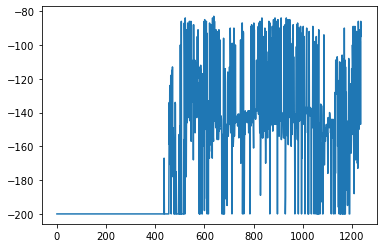

In [5]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -110:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [6]:
env.close()